# Getting Started Notebook: Stage 2

This notebook illustrates how to use the datasets provided to you and will be required to submit your first model.
This notebook follows the same structure as the stage 1 notebook, but you will need to perform some additional steps such as feature extraction.

## 0. Dependencies

This notebook requires several Python **3** packages, which are included in Anaconda 3 for Python 3.8, which is the python distribution we recommend you to use throughout this course.
The package versions listed below have been used for testing and are confirmed to work well.
We strongly recommend you to install these specific versions to ensure this notebook works as expected and we can offer you optimal support throughout the competition.

python: 3.8

scikit-learn: 1.0.0

numpy: 1.20.1

matplotlib: 3.4.3

In [1]:
!pip install scikit-learn==1.0.0 numpy matplotlib

## 1. How to use this Notebook

This Notebook is based on the stage 1 notebook and provides a sample structure to load data, extract features, and train and tune a scikit-learn pipeline for stage 2.
You are not required to follow this exact structure.
After you have completed all necessary steps, this notebook will generate a CSV (.csv) file to be submitted on the [Kaggle competition page](https://www.kaggle.com/c/ugentml21-slc-2/)

In [2]:
# your data, used to name the output file
student_id = "02010068"
student_lastname = "Dagrain" 
student_firstname = "Miguel"

# change this if you would like your submission outputfile to have a more detailed name, e.g. submission_with_special_preprocessing 
submission_prefix='submission'

# whether or not you want your created models and submissions versioned using timestamps
# (setting this to False will overwrite previously exported model and submission files of the same name)
use_timestamps = True

## 2. Loading the data

The dataset contains videos of people signing in Flemish sign language (Vlaamse Gebarentaal). It consists of 15 classes corresponding to lexical signs. From these videos, 3D keypoints were extracted using MediaPipe Holistic. In total, there are 125 keypoints, resulting in 375 (=3x125) floating point values per video frame.

In this stage, we expect that you perform your own feature engineering. As a baseline, you can start by extracting the same set of features as we did for stage 1.
You can then compare this and future models with the baseline on the Kaggle competition page.

As a reminder: the set of features in stage 1 were the time averages of all keypoint coordinates over the first and the second half of the sample frames, so 750 features in total.

We start by importing the libraries we need: 
- sklearn and numpy to do machine learning, 
- csv and pickle read the data and write out submission and model files, 
- time and os to keep organized with the files we output,
- matplotlib to perform visualizations.
We also import some specific sklearn components as well as an utils library with some handy extra functions.

In [3]:
import sklearn
import numpy as np
import csv
import pickle
import time
import os
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV

import utils_for_students

We can use our utils_for_students library to load the data from disk. Remember to put the [unzipped files from the competition page](https://www.kaggle.com/c/ugentml21-slc-2/data) into the right paths on your filesystem.

**Note: stage 2 uses different data files than stage 1!**

In [4]:
train_samples = utils_for_students.load_dataset_stage2('data/stage2_labels_train.csv', 'train')
test_samples = utils_for_students.load_dataset_stage2('data/stage2_ids_test.csv', 'test')

For the train data, we get a list of python dictionaries, where each dictionary corresponds to one sign language clip. The dictionary has the following keys:

In [5]:
train_samples[0].keys()

dict_keys(['path', 'id', 'label', 'signer'])

For the test data, we also get a list of python dictionaries, but with fewer keys:

In [6]:
test_samples[0].keys()

dict_keys(['path', 'id'])

You can load an individual sample using the provided code.

In [7]:
sample = train_samples[0]

landmark_sequence = utils_for_students.load_sample_stage2(os.path.join('data/stage2/train/', sample['path']))

We can use the utility code to create a visualization of individual video frames of every sign instance.

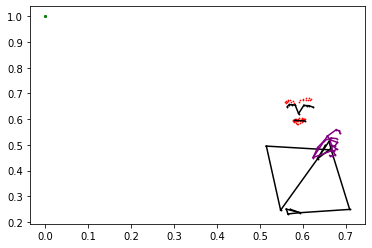

In [8]:
FRAME_INDEX = 0

utils_for_students.visualize_pose(landmark_sequence[FRAME_INDEX], plt)

In order to get a better grasp of every class in the dataset, we provide some additional information here.

There are 15 different classes. Each class corresponds to a sign. Signs can be annotated using sign glosses, which are representations of signs in written form in a spoken language. In the below table, we list all glosses, the English meaning of the corresponding sign, and provide a link to the Flemish sign language dictionary so that you can see an example performance of that sign.

| Gloss             | English meaning | Dictionary URL                                                                                        |
|-------------------|-----------------|-------------------------------------------------------------------------------------------------------|
| c.AF              | Done, finished  | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/AF/AF-B-209.mp4          |
| c.OOK             | Too, also       | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/OO/OOK-A-8491.mp4        |
| ZELFDE-A          | The same        | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/ZE/ZELFDE-A-14290.mp4    |
| AUTO-RIJDEN-A     | To drive a car  | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/RI/RIJDEN-C-9982.mp4     |
| HEBBEN-A          | To have         | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/HE/HEBBEN-A-4801.mp4     |
| HAAS-oor          | Hare            | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/HA/HAAS-B-16147.mp4      |
| AANKOMEN-A        | To arrive       | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/AA/AANKOMEN-A-39.mp4     |
| SCHILDPAD-Bhanden | Turtle          | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/SC/SCHILDPAD-A-10503.mp4 |
| WAT-A             | What            | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/WA/WAT-A-13657.mp4       |
| c.ZIEN            | To see          | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/BE/BEKIJKEN-A-1157.mp4   |
| NAAR-A            | Towards         | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/GA/GA-NAAR-A-4032.mp4    |
| MOETEN-A          | To must         | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/MO/MOETEN-D-17652.mp4    |
| C: 1              | 1               | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/1-/1-A-15277.mp4         |
| GOED-A            | Good            | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/GO/GOED-C-4413.mp4       |
| C: 2              | 2               | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/2-/2-A-15278.mp4         |

## 3. Feature Extraction

For stage 1, we performed feature extraction for you.

In this stage, you will need to perform feature extraction yourself.

In [9]:
#from frame_avg import extract_features
#from sklearn.preprocessing import normalize
from vectors import extract_features
# def extract_features(pose_sequence):
#     NUM_SLICES = 2 #TODO : inspect how performance changes with more slices
#     size = len(pose_sequence[0])*len(pose_sequence[0][0]) # number of keypoints * number of values per keypoint
#     pose_sequence = split_features_into_frames(pose_sequence, NUM_SLICES)
#     poses = np.array_split(pose_sequence,NUM_SLICES) #some of these may be empty
# #     poses_normalized = []
# #     for pose in poses:
# #         pose_sorted = pose.reshape(int(pose.shape[0]/3), 3)
# #         pose_sorted = pose_sorted - pose_sorted.mean(axis=0)
# #         #pose_sorted_normalized = sklearn.preprocessing.normalize(pose_sorted)
# #         pose = pose_sorted.flatten()
# #         poses_normalized.append(pose)
#     #poses_normalized = sklearn.preprocessing.normalize(poses_normalized)
#     features = poses[0] #save the initial position
#     #here you cut to much information, in the middle of the video we are not necessarily on the same position
#     for i in range(1, NUM_SLICES):
#         vector = poses[i] - poses[i-1]
#         features  = np.append(features, vector)
#     return features
#     #return np.array(poses_normalized).flatten()

In [10]:
from utils_feature_preprocessing import correct_zeros
# Concatenate the training set features.
X_train = []
y_train = []
signers_train = []
for sample in train_samples:
    pose_sequence = utils_for_students.load_sample_stage2(os.path.join('data/stage2/train/', sample['path']))
    pose_sequence = correct_zeros(pose_sequence)
    X_train.append(extract_features(pose_sequence))
    y_train.append(sample['label'])
    signers_train.append(sample['signer'])
    
# Concatenate the test set features.
X_test = []
test_ids = []
for sample in test_samples:
    pose_sequence = utils_for_students.load_sample_stage2(os.path.join('data/stage2/test/', sample['path']))
    pose_sequence = correct_zeros(pose_sequence)
    X_test.append(extract_features(pose_sequence))
    test_ids.append(sample['id'])

#Combining to numpy array
X_train = np.stack(X_train)
X_test = np.stack(X_test)

# Encode the labels as integers
label_encoder = utils_for_students.label_encoder()
y_train = label_encoder.transform(y_train)

In [11]:
print(X_train.shape)
print(X_test.shape)
print(X_train[0])

(2191, 750)
(541, 750)
[ 5.91577282e-01  3.78286968e-01 -2.86928013e-01  6.03643487e-01
  3.46427446e-01 -2.58362256e-01  6.10377789e-01  3.47145076e-01
 -2.58760711e-01  6.17259234e-01  3.47173274e-01 -2.58759312e-01
  5.82812428e-01  3.45205933e-01 -2.62428480e-01  5.76285193e-01
  3.44554747e-01 -2.62777999e-01  5.70241481e-01  3.43811611e-01
 -2.63034711e-01  6.27112011e-01  3.53380963e-01 -9.19988013e-02
  5.63872258e-01  3.51935064e-01 -1.09662503e-01  6.06627146e-01
  4.06948984e-01 -2.19758605e-01  5.82404792e-01  4.04490660e-01
 -2.27568862e-01  6.65919234e-01  5.14250706e-01  9.42027379e-03
  5.16301920e-01  5.04570842e-01 -6.29098974e-02  7.05310414e-01
  7.50590682e-01 -8.58137080e-02  5.44967661e-01  7.47737060e-01
 -2.57351602e-01  5.94993909e-01  7.59710014e-01 -3.54945322e-01
  6.19667431e-01  5.40412545e-01 -5.42192280e-01  5.67901512e-01
  7.63972978e-01 -4.10544410e-01  6.50521199e-01  4.99925216e-01
 -6.24869655e-01  5.62727243e-01  7.41009136e-01 -4.11703030e-01
  

## 4. Creating pipelines for preprocessing and feature selection 

Now, we are ready to define our pipelines. You can create the same pipeline as for stage 1 as a baseline, but you will be expected to tune both the feature engineering
and pipeline parts of your model iteratively to improve your results.

In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.feature_selection import SelectFwe, SelectFromModel, SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.decomposition import PCA

#chosen PCA instead of LDA as the n_components of LDA has to be <= min(n_classes - 1, n_features) which is 14 in
#this case (down from 750). Which is likely to little given the that the features are only x, y or z values.
preprocessing = Pipeline([
     ('normalizer', Normalizer()),
     ('scaler', MinMaxScaler()),
     ('decompose', PCA()),
     ('rescale', MinMaxScaler()),
                        ]) 

#TODO: define feature selection pipeline here
#first we remove the features that mithingsght lead to false results
#then we use selectFromModel to assign weights and take the least important features away for generalization
#ofcourse only using linear regression models (the same model as the actual classifier)
feature_selection = Pipeline([
    #('selectFromModel', SelectFromModel(RidgeClassifier(fit_intercept=False))),
    ('selectKBest', SelectKBest()),
                            ]) 

## 5. Define a suitable classifier
With your preprocessing and feature selection in place, it is now time to define the final element: a suitable classifier. 

In [13]:
#TODO: define proper classifier
classifier = RidgeClassifier(fit_intercept=False, class_weight="balanced")

## 6. Set up hyperparameter grid for [GridsearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) object.

Now, define your GridSearchCV hyperparameter grid and object.


In [14]:
param_grid = {
    'preprocessing__decompose__n_components':[180],#["mle", None, 50,100,110,120,130,140,150,180,190,200,210,220,250,300,350,400,450,500,550,600,650,700,750],
    'feature_selection__selectKBest__score_func': [f_classif],# mutual_info_classif],
    'feature_selection__selectKBest__k': [180],#[50,100,110,120,130,140,150,180,190,200,210,220,250,300,350,400,450,500,550,600,650,700,750],
    'classifier__alpha': [1],#[1e9, 1e8, 1e7, 1e6, 1e5, 1e4, 1e3, 1e2, 1],
    'classifier__tol': [1.0e-5],#[1.0e-5, 1.0e-4,  1.0e-2, 1.0e-1, 0.2, 0.5, 0.7, 0.9]
}

## 7. Define the number of crossvaldation folds and how to split

Now, you should define the number of CV folds and how to split the data.
Assuming you had a correct split in the first stage of the competition, you can re-use the same code.


In [15]:
n_folds = 4

# The function below is just an example!
#TODO: write a better split function here?
#split according to signer for i.i.d. sets
def create_folds(X,y,n_folds):
    folds = []
    cv_object = StratifiedGroupKFold(n_splits = n_folds)
    for (train_indices, val_indices) in  cv_object.split(X_train, y_train, groups=signers_train):
        folds.append((train_indices,val_indices))
    return folds

## 8. Training the model
Now it is time to put everything together and train the model. As you can see, `GridsearchCV` takes the pipelines as well as the classifier and the hyperparameter dictionary you defined, and uses `create_folds` to create list of train and test indices for each split. Then the model is trained using `cv.fit()` and the model and submission files are written to the file system.

In stage 2, this cell is no longer locked and you are free to edit it as you like.

In [16]:
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('feature_selection', feature_selection),
    ('classifier', classifier)])

folds = create_folds(X_train,y_train,n_folds)
assert isinstance(folds,list),'Folds must be presented as tuples of train and test index lists' 

# train model
cv = GridSearchCV(pipeline, param_grid, n_jobs=4, cv=folds, verbose=1, return_train_score=True, refit=True)
cv.fit(X_train, y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


GridSearchCV(cv=[(array([   0,    1,    2, ..., 2187, 2189, 2190]),
                  array([   4,    6,   12,   13,   16,   21,   29,   43,   49,   58,   60,
         65,   70,   73,   74,   81,   85,   86,   89,   91,   92,  100,
        102,  103,  104,  105,  107,  109,  121,  122,  124,  126,  127,
        130,  150,  154,  159,  163,  164,  170,  172,  178,  181,  182,
        199,  204,  207,  208,  209,  212,  213,  220,  222,  226,  229,
        237,  242,  246,  253,  254,  264,  267,  275,  278,  279,  283,
        284,  290,  299,  300,  305,  309,  313,  314,  317,  318,  320,
        322,  32...
                                       ('classifier',
                                        RidgeClassifier(class_weight='balanced',
                                                        fit_intercept=False))]),
             n_jobs=4,
             param_grid={'classifier__alpha': [1], 'classifier__tol': [1e-05],
                         'feature_selection__selectKBest__k': [18

In [17]:
# write out model
#make sure student data is filled in to give the file a speaking name
assert student_id is not None and student_lastname is not None and student_firstname is not None, 'Please fill in your Name and Student Id'

submission_dirname = 'submission'
if use_timestamps:
    timestamp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
    filename_model = os.path.join(submission_dirname,f'stage2_model_{student_id}_{student_lastname}_{student_firstname}_{timestamp}.pkl')
    filename_submission =  os.path.join(submission_dirname,f'stage2_{submission_prefix}_{student_id}_{student_lastname}_{student_firstname}_{timestamp}.csv')
else:
    filename_model = os.path.join(submission_dirname,f'stage2_model_{student_id}_{student_lastname}_{student_firstname}.pkl')
    filename_submission =  os.path.join(submission_dirname,f'stage2_{submission_prefix}_{student_id}_{student_lastname}_{student_firstname}.csv')

if not os.path.exists(submission_dirname):
    os.mkdir(submission_dirname)    

with open(filename_model,'wb') as file:
    pickle.dump(cv,file)
    
prediction = label_encoder.inverse_transform(cv.best_estimator_.predict(X_test))
utils_for_students.create_submission_file(filename_submission, test_ids, prediction)

## 9. Printing scores
Here we simply extract a bit more information about the individual scores obtained by the classifers we trained to fit the individual folds. Maybe a few plots may be useful to better understand what your classifier is doing? 

In [18]:
results = cv.cv_results_
mean_train_score = results['mean_train_score'][cv.best_index_]
std_train_score = results['std_train_score'][cv.best_index_]
mean_cv_score = results['mean_test_score'][cv.best_index_]
std_cv_score = results['std_test_score'][cv.best_index_]

print('Training accuracy {} +/- {}'.format(mean_train_score, std_train_score))
print('Cross-validation accuracy: {} +/- {}'.format(mean_cv_score, std_cv_score))

print('Best estimator:')
print(cv.best_estimator_)

Training accuracy 0.8692221262090918 +/- 0.014325113577318778
Cross-validation accuracy: 0.6651429147118103 +/- 0.034125873267856474
Best estimator:
Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('normalizer', Normalizer()),
                                 ('scaler', MinMaxScaler()),
                                 ('decompose', PCA(n_components=180)),
                                 ('rescale', MinMaxScaler())])),
                ('feature_selection',
                 Pipeline(steps=[('selectKBest', SelectKBest(k=180))])),
                ('classifier',
                 RidgeClassifier(alpha=1, class_weight='balanced',
                                 fit_intercept=False, tol=1e-05))])


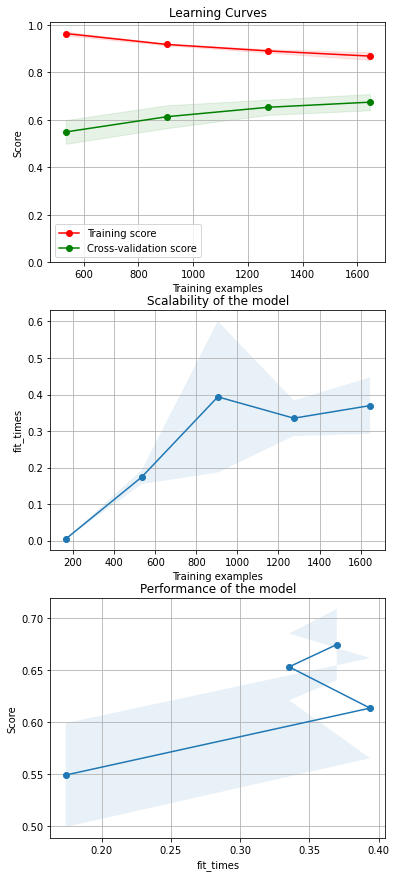

In [34]:
from utils_data_analysis import plot_learning_curve

fig, axes = plt.subplots(3, 1, figsize=(6, 15))
title = "Learning Curves"

plot_learning_curve(
    cv.best_estimator_, title, X_train, y_train, axes=axes, ylim=(0.0, 1.01), cv=folds, n_jobs=4
)

plt.show()

Best parameters set found on development set:  {'classifier__alpha': 1, 'classifier__tol': 1e-05, 'feature_selection__selectKBest__k': 180, 'feature_selection__selectKBest__score_func': <function f_classif at 0x7f6ebf2154c0>, 'preprocessing__decompose__n_components': 180}
Grid scores on training data set:



ValueError: x and y must have same first dimension, but have shapes (23,) and (1,)

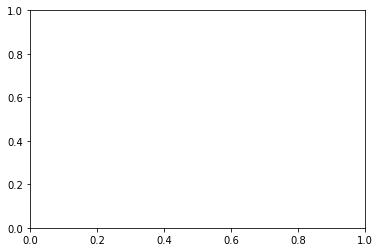

In [19]:
# use for visualizing certain evolutions

import matplotlib.pyplot as plt

print("Best parameters set found on development set: ",cv.best_params_)
# store the best optimization parameter for later reuse
bestC2 = cv.best_params_['classifier__alpha']

print("Grid scores on training data set:")
print()
cv_means = cv.cv_results_['mean_test_score']
cv_stds = cv.cv_results_['std_test_score']

train_means = cv.cv_results_['mean_train_score']
train_stds = cv.cv_results_['std_train_score']

#C_range = [0.92, 0.9, 0.8, 0.75, 0.5, 0.2, 1e-1, 5e-2, 2.5e-2]
#C_range = ["0.1*mean","0.15*mean","0.2*mean","0.25*mean", "0.75*mean", "1*mean", "1.2*mean", "1.25*mean", "1.5*mean", "0.2*median","0.3*median","0.4*median","0.5*median", "0.75*median", "1*median", "1.25*median", "2*median", "2.05*median", "2.1*median", "2.2*median"]
C_range = [50,100,110,120,130,140,150,180,190,200,210,220,250,300,350,400,450,500,550,600,650,700,750]
#C_range = [True, False]
#C_range = ['mle', 140, 150, 160, 170, 180, 190, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750]
#C_range = [1.0e10, 1.0e9, 1.0e8, 1.0e7, 1.0e6, 1.0e5, 1.0e4, 1.0e3, 1.0e2, 10, 1.0]
#C_range = [1.0e-5, 1.0e-4,  1.0e-2, 1.0e-1, 0.2, 0.5, 0.7, 0.9]
# C_range = [1.0e-6, 1.0e-4, 1.0e-2, 1.0e-1, 0.2, 0.5, 0.8]
#C_range = [1e9, 1e8, 1e7, 1e6, 1e5, 1e4, 1e3, 1e2, 1, 1e-1, 1e-2, 1e-3]
#C_range = [1e-2, 2.5e-2, 5e-2, 1e-1, 1.5e-1, 2e-1, 3e-1, 5e-1, 6e-1, 6.5e-1, 7e-1, 9e-1, 9.9e-1, 1]
#C_range = ["f_classif", "chi2"]
plt.figure()
plt.plot(C_range,train_means,'g-',label="train")
plt.plot(C_range,cv_means,'r-',label="validate")
#plt.plot(np.log10(C_range),train_means,'g-',label="train")
#plt.plot(np.log10(C_range),cv_means,'r-',label="validate")
plt.xlabel("classifier__C")
plt.ylabel("Accuracy")
plt.legend()
plt.show()